# Example for running greenlight, displaying and analyzing simulation results

`GreenLight/notebooks/greenlight_example`<br>
Copyright (c) 2025 David Katzin, Wageningen Research Foundation<br>
SPDX-License-Identifier: BSD-3-Clause-Clear<br>
https://github.com/davkat1/GreenLight

Note: a script version of this notebook is available at scripts/greenlight_example.py

## Running greenlight

In [1]:
"""
General imports and settings
"""
%load_ext autoreload
%autoreload 2

import datetime as dt
import os
import sys

import matplotlib  # If this fails, try to pip install matplotlib-inline
import pandas as pd

# Set up directories
project_dir = os.path.abspath(os.path.join(os.path.abspath(""), ".."))
sys.path.append(project_dir)
import greenlight

In [2]:
"""
Simulation settings
"""
# Name of file containing the simulation output
output_file_name = "greenlight_example_output.csv"  

# Name of the unprocessed EnergyPlus CSV
original_energyPlus_csv = "NLD_Amsterdam.062400_IWECEPW.csv"  

# Chosen name for the processed EnergyPlus data
formatted_csv_name = "weather_ams_katzin_2021.csv"  

# First day of simulation season
start_date = dt.datetime(year=2020, month=9, day=27)  

# Length of simulated season, in days
simulation_length = 3  

In [3]:
"""
Set up simulation arguments
"""
# Base directory to be used by the model
base_path = os.path.join(project_dir, "greenlight", "models")

# Location (relative to base_path) of the main definition of the Katzin 2021 model, which will be used here
model = os.path.join("katzin_2021", "definition", "main_katzin_2021.json")

# Location of weather files, relative to base_path
original_file_directory = os.path.join("katzin_2021", "input_data", "energyPlus_original")
formatted_file_directory = os.path.join("katzin_2021", "input_data", "energyPlus_formatted")

# Modify directories to absolute path
original_file_directory = os.path.abspath(os.path.join(base_path, original_file_directory))
formatted_file_directory = os.path.abspath(os.path.join(base_path, formatted_file_directory))

# Outputs will be placed under katzin_2021/output
output_dir = os.path.join("katzin_2021", "output")

print(f"Base path: {base_path}\nModel location: {model}\nOutput location: {output_dir}")
# Numbers of days to simulate, in seconds
options = {
    "options": {"t_end": str(simulation_length * 24 * 3600)}
}

# Any other modification to the model
mods = [{"thetaLampMax": {"definition": "120"}}]  # Change the maximum lamp intensity to 120 W/m2

print(f"Number of days to simulate: {simulation_length}\nOther mods: {mods}")

Base path: C:\Users\katzi001\OneDrive - Wageningen University & Research\git\gitwur\GreenLight\greenlight\greenlight\models
Model location: katzin_2021\definition\main_katzin_2021.json
Output location: katzin_2021\output
Number of days to simulate: 3
Other mods: [{'thetaLampMax': {'definition': '120'}}]


In [4]:
"""
Add weather data
"""
# Convert original file into formatted file - with the required start and end date
formatted_file_name = greenlight.convert_energy_plus(
    os.path.join(original_file_directory, original_energyPlus_csv),
    os.path.join(formatted_file_directory, formatted_csv_name),
    t_out_start=start_date,
    t_out_end=start_date + dt.timedelta(days=simulation_length),
)

# Include the generated file in the simulation
mods.append(os.path.join(formatted_file_directory, formatted_file_name))

Converted EnergyPlus file:
C:\Users\katzi001\OneDrive - Wageningen University & Research\git\gitwur\GreenLight\greenlight\greenlight\models\katzin_2021\input_data\energyPlus_original\NLD_Amsterdam.062400_IWECEPW.csv
and saved the results to:
C:\Users\katzi001\OneDrive - Wageningen University & Research\git\gitwur\GreenLight\greenlight\greenlight\models\katzin_2021\input_data\energyPlus_formatted\weather_ams_katzin_2021_from_sep_27_000000.csv
Start date of generated dataset: 2020-09-27 00:00:00
End date of generated dataset: 2020-09-30 00:00:00
Length: 3 days, 0:00:00


In [5]:
"""
Run the model
"""
input_arg = [model, options, mods]
output_arg = os.path.join(output_dir, output_file_name)
mdl = greenlight.GreenLight(base_path=base_path, input_prompt=input_arg, output_path=output_arg)
mdl.run()



Loading model from katzin_2021\definition\main_katzin_2021.json
Loading model from C:\Users\katzi001\OneDrive - Wageningen University & Research\git\gitwur\GreenLight\greenlight\greenlight\models\katzin_2021\input_data\energyPlus_formatted\weather_ams_katzin_2021_from_sep_27_000000.csv
Simulation started at time (ISO format): 2025-09-19T17:18:12.264388
Running: 100.00%

Simulation complete at time (ISO format): 2025-09-19T17:18:19.575402
Simulated 3.0 days
Elapsed time: 7.311014413833618 seconds
Output saved to file katzin_2021\output\greenlight_example_output.csv
Model structure log saved to katzin_2021\output\greenlight_example_output_model_struct_log.json
Simulation log saved to katzin_2021\output\greenlight_example_output_simulation_log.txt


## Load, show, and interpret results

In [6]:
"""
Load simulation result
"""
output_df = pd.read_csv(os.path.join(base_path, output_dir, output_file_name), header=None, low_memory=False)
variable_names = output_df.iloc[0]
descriptions = output_df.iloc[1]
units = output_df.iloc[2]

# Reformat the DataFrame with variable names as columns
output_df = output_df.iloc[3:].reset_index(drop=True).apply(pd.to_numeric)
output_df.columns = variable_names

# Create dictionaries for descriptions and units
descriptions_dict = dict(zip(variable_names, descriptions))
units_dict = dict(zip(variable_names, units))

print(output_df.head(5))

0     Time       tCan       tAir       tFlr       tSo1       tSo2       tSo3  \
0      0.0  20.500000  16.500000  16.500000  16.500000  13.364000  10.228000   
1   3600.0  16.880795  18.795515  15.881166  15.400663  13.605127  10.377774   
2   7200.0  16.300064  18.092815  15.346415  14.962760  13.594767  10.517064   
3  10800.0  16.427551  18.073095  15.135274  14.717305  13.514278  10.635409   
4  14400.0  16.740916  18.519076  15.253889  14.737601  13.455167  10.733695   

0      tSo4      tSo5     tThScr  ...  parCan           rS    j     vecCanAir  \
0  7.092000  3.956000  16.500000  ...     0.0  2395.783162  0.0  6.475058e-10   
1  7.129474  4.004379  16.500030  ...     0.0  1380.923294  0.0  1.126255e-09   
2  7.169531  4.052565  16.488140  ...     0.0  1423.980397  0.0  1.176934e-09   
3  7.211693  4.100572  16.062432  ...     0.0  1603.172420  0.0  1.135780e-09   
4  7.255407  4.148412  14.038228  ...     0.0  1989.051705  0.0  1.000651e-09   

0    p    r      mvCanAir  mcAir

In [10]:
"""
Choose variables to show
"""
# Choose variables out of output_df.columns
# For a description of a variable var, see descriptions_dict[var]. For the unit, see units_dict[var]
chosen_vars = ["tOut", "tAir", "tCan", "qLampIn", "lai", "cFruit", "mcFruitHar", "hBoilPipe", "hBoilGroPipe"]

for var in chosen_vars:
    print(f"{var}: {descriptions_dict[var]} ({units_dict[var]})")

tOut: Outdoor temperature (°C)
tAir: Temperature of the air in the main compartment of the greenhouse (below the screen) (°C)
tCan: Canopy temperature (°C)
qLampIn: Lamp electrical input (W m**-2)
lai: Leaf area index (m**2 {leaf} m**-2 {floor})
cFruit: Carbohydrates in the fruit (mg{CH2O} m**-2)
mcFruitHar: Fruit harvest rate (mg{CH2O} m**-2 s**-1)
hBoilPipe: Heat flux from the boiler to the heating pipe (W m**-2)
hBoilGroPipe: Heat from boiler to grow pipes (W m**-2)


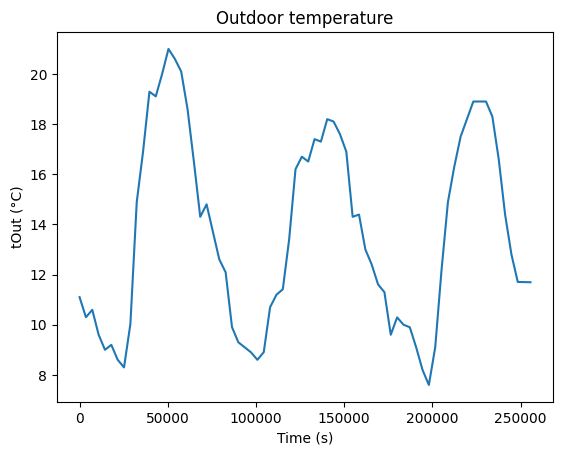

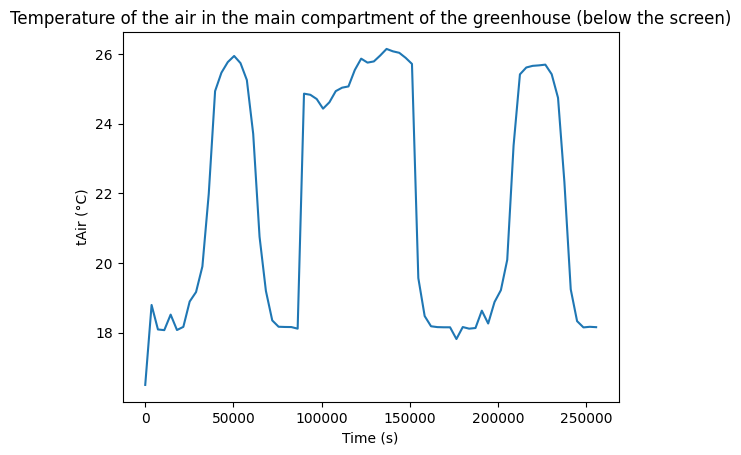

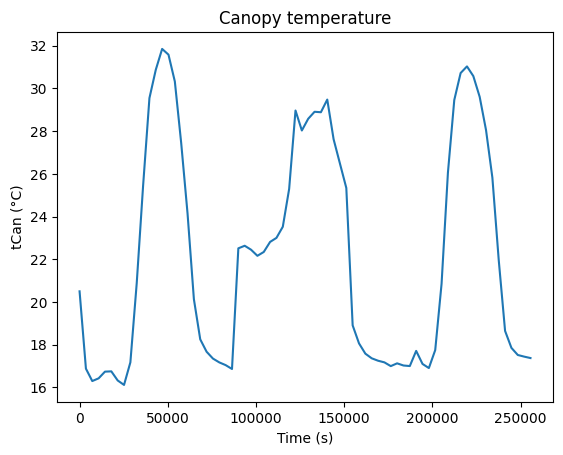

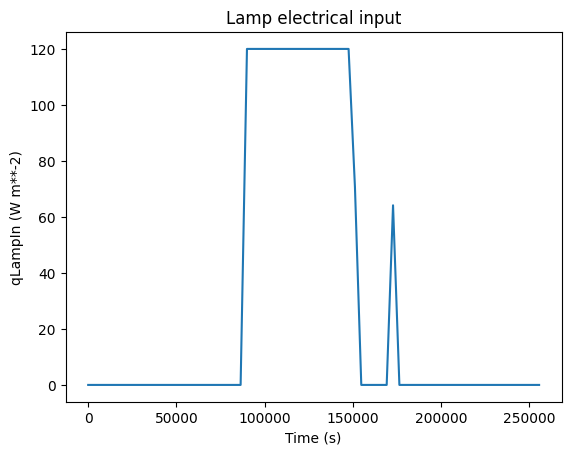

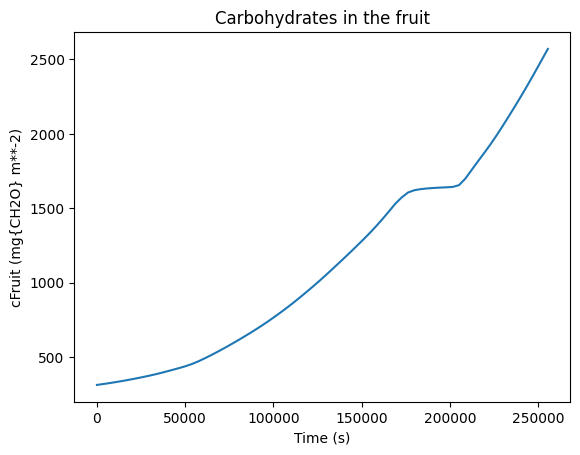

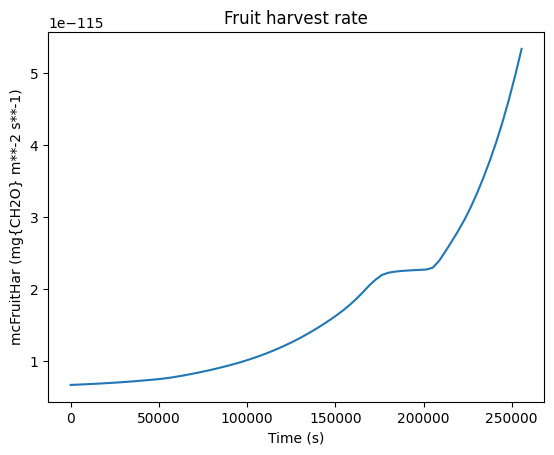

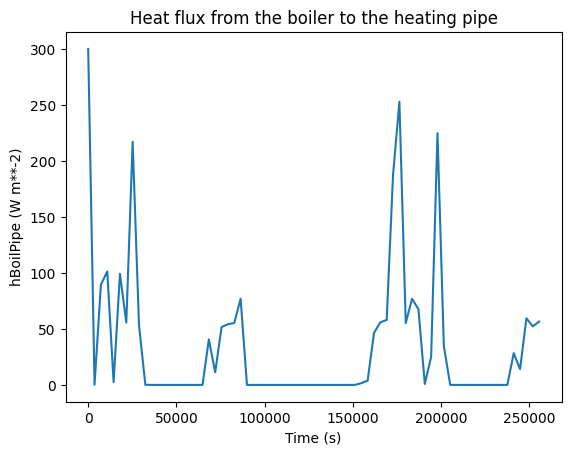

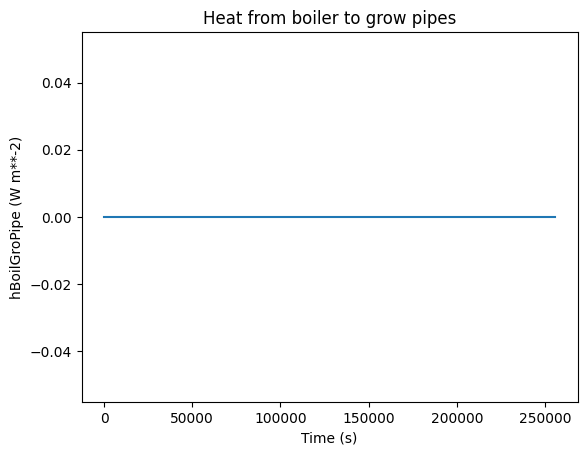

In [11]:
"""
Show some graphs
"""
# Choose variables out of output_df.columns
# For a description of a variable var, see descriptions_dict[var]. For the unit, see units_dict[var]
chosen_vars = ["tOut", "tAir", "tCan", "qLampIn", "cFruit", "mcFruitHar", "hBoilPipe", "hBoilGroPipe"]

for var in chosen_vars:
    output_df.plot(x="Time", y=var, xlabel="Time (s)", ylabel=f"{var} ({units_dict[var]})", title=descriptions_dict[var], legend=None);

In [12]:
"""
Calculate yield, energy use, CO2 use, water use
"""
# The time steps (in s) in the output data
time_step = output_df.loc[1,"Time"] - output_df.loc[0,"Time"]
print(f'Time step size: {time_step} seconds')
print(f'Simulation length: {(output_df["Time"].iloc[-1] - output_df["Time"].iloc[0])/86400} days')

# Assumed fruit dry matter content
dmc = 0.06

# Total yield, kg fresh weight per m**2
tot_yield = time_step*sum(output_df["mcFruitHar"])*1e-6/dmc
print(f"Yield: {tot_yield} kg/m2")

# Energy for heating, MJ m**2
energy_heat = time_step*(sum(output_df["hBoilPipe"]) + sum(output_df["hBoilGroPipe"]))*1e-6
print(f"Energy used for heating: {energy_heat} MJ/m2")

# Energy for lighting, MJ m**2
energy_light = time_step*(sum(output_df["qLampIn"]) + sum(output_df["qIntLampIn"]))*1e-6
print(f"Energy used for lighting: {energy_light} MJ/m2")


# Total CO2 use (for CO2 injection), kg m**2
tot_co2 = time_step*sum(output_df["mcExtAir"])*1e-6
print(f"CO2 use: {tot_co2} kg/m2")

# Assumed ratio between total transpiration and total irrigation
# If drain is recirculated, transpiration is about 90% of irrigation, irrigation is about 1.1 times transpiration
trans_to_irrig = 1.1
# Total water use (for irrigation), kg m**2
tot_h20 = time_step*trans_to_irrig*sum(output_df["mvCanAir"])
print(f"Water use for irrigation: {tot_h20} liters/m2")

Time step size: 3600.0 seconds
Simulation length: 2.9583333333333335 days
Yield: 7.397950133611374e-115 kg/m2
Energy used for heating: 9.038991703646733 MJ/m2
Energy used for lighting: 7.829793238124036 MJ/m2
CO2 use: 0.42660744352762314 kg/m2
Water use for irrigation: 1.9664389160479403 liters/m2
